In [117]:
from sklearn.datasets import fetch_20newsgroups
from matplotlib import pyplot as plt
import numpy as np
from numpy import array

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF


import time
import itertools

import pickle

In [182]:
# contingency table (confusion matrix)
def plot_contingency_table(cm, title='Contingency Table',
                           cmap=plt.cm.YlGnBu,
                           actual_class_names=['Class 1', 'Class 2'],
                           cluster_class_names=['Cluster 1', 'Cluster 2']):
    plt.gcf().clear()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(actual_class_names))
    plt.xticks(tick_marks, actual_class_names)
    plt.yticks(tick_marks, cluster_class_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center")

    plt.tight_layout()
    plt.ylabel('Cluster Class', fontsize=12)
    plt.xlabel('Actual Class', fontsize=12)
    plt.show()
    
def k_means_clustering(training_data,
                       target_set,
                       n_clusters=8,
                       random_state=None,
                       max_iter=300,
                       n_init=10,
                       actual_class_names=['Class 1', 'Class 2'],
                       cluster_class_names=['Cluster 1', 'Cluster 2']):
    start = time.time()
    km = KMeans(n_clusters=n_clusters,random_state=random_state,max_iter=max_iter,n_init=n_init)
    km.fit(training_data)
    print("Finished clustering with %i seeds in %f seconds" % (n_init, time.time()-start))

    contin_matrix = metrics.cluster.contingency_matrix(target_set, km.labels_)
    print("Show Contingency Matrix:")
    
    plot_contingency_table(contin_matrix, actual_class_names=actual_class_names, cluster_class_names=cluster_class_names)
    
    print("Report 5 Measures for K-Means Clustering")
    
    homogeneity = metrics.homogeneity_score(target_set, km.labels_)
    completeness = metrics.completeness_score(target_set, km.labels_)
    v_measure = metrics.v_measure_score(target_set, km.labels_)
    adjusted_rand_index = metrics.adjusted_rand_score(target_set, km.labels_)
    adjusted_mutual_info = metrics.adjusted_mutual_info_score(target_set, km.labels_)

    print("Homogeneity Score: %f" % homogeneity)
    print("Completeness Score: %f" % completeness)
    print("V-Measure Score: %f" % v_measure)
    print("Adjusted Rand Index: %f" % adjusted_rand_index)
    print("Adjusted Mutual Information: %f" % adjusted_mutual_info)
    
    results = {
        "homogeneity": homogeneity,
        "completeness": completeness,
        "v_measure": v_measure,
        "adjusted_rand_index": adjusted_rand_index,
        "adjusted_mutual_info": adjusted_mutual_info }
    
    return results, km


def svd_dimension_reduction(training_data, n_components=2):
    start = time.time()
    svd = TruncatedSVD(n_components = n_components)
    svd_dataset = svd.fit_transform(training_data)
    print("SVD complete after %f seconds" % (time.time()-start))
    return svd_dataset , svd

def nmf_dimension_reduction(training_data, n_components=None):
    start = time.time()
    nmf = NMF(n_components=n_components, random_state=0)
    nmf_dataset = nmf.fit_transform(training_data)
    print("NMF complete after %f seconds" % (time.time()-start))
    return nmf_dataset , svd

    
def plot_percent_variance(svd):
    plt.gcf().clear()
    print("Plot Percent of Variance")
    plt.plot(np.cumsum(svd.explained_variance_ratio_[:1000]))
    plt.xlabel("Dimension Index")
    plt.ylabel("Percentage of Total Variance")
    plt.show()    
    
def plot_histogram(method, measure, ydata, x_labels = ['1', '2', '3', '5', '10', '20', '50', '100', '300'], height=range(1,10)):
    plt.gcf().clear()
    fig, ax = plt.subplots()
    ax.set_xticks([i+0.25 for i in height])
    ax.set_xticklabels(x_labels, fontsize = 12)
    
    rects = plt.bar([i for i in height], ydata, 0.5, align='edge', alpha = 0.8)
    plt.xlabel('Number of Principal Components r', fontsize = 14)
    plt.ylabel('Measure Score', fontsize = 14)
    plt.title(measure+' ('+method+')', fontsize = 18)
    plt.axis([0.5,10,0,1])
    
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height, '%.3f' % float(height), ha='center', va='bottom')
    
    plt.show()   
    

def i_love_graphing_points(k_means_object, clustering_result, ground_truth_dataset, title_name = ''):
    plt.gcf().clear()
    fig = plt.figure(figsize=(12,6))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    ax1.scatter(x=clustering_result[:,0], y=clustering_result[:,1], c=k_means_object.labels_, edgecolors='k', linewidth=0.25, s=30, cmap=plt.get_cmap('tab20'),vmin=0, vmax=20, alpha=0.5)    
    ax1.set_title('Clustering Result')

    ax2.scatter(x=clustering_result[:,0], y=clustering_result[:,1], c=ground_truth_dataset, edgecolors='k', linewidth=0.25, s=30, cmap=plt.get_cmap('tab20'),vmin=0, vmax=20, alpha=0.5)
    ax2.set_title('Ground Truth')
    fig.suptitle(f'{title_name} Visualization')
    plt.show()
    # plt.savefig("p4b_vis_nmf_%s.pdf" % normalizer_name)
    

In [141]:
computer_technology_subclasses = ['comp.graphics',
                                  'comp.os.ms-windows.misc',
                                  'comp.sys.ibm.pc.hardware',
                                  'comp.sys.mac.hardware']

recreational_activity_subclasses = ['rec.autos',
                                    'rec.motorcycles',
                                    'rec.sport.baseball',
                                    'rec.sport.hockey']

categories = computer_technology_subclasses + recreational_activity_subclasses

In [142]:
dataset = fetch_20newsgroups(subset='all',categories=categories, shuffle=True, 
                             random_state=42, remove=('headers', 'footers'))

dataset_binary_target = [0 if t<4 else 1 for t in dataset.target]

In [143]:
# QUESTION 1: Report the dimensions of the TF-IDF matrix you get.

In [144]:
# Generate TF-IDF Data, with min_df=3, removed stop words, no stemming
vectorizer = CountVectorizer(min_df=3, stop_words='english')
X_counts = vectorizer.fit_transform(dataset.data)

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

# Print the shape of the datasets
print("QUESTION 1: Report the dimensions of the TF-IDF matrix you get\n")
print('X_tfidf:',X_tfidf.shape)


QUESTION 1: Report the dimensions of the TF-IDF matrix you get

X_tfidf: (7882, 23522)


In [145]:
# QUESTION 2: Report the contingency table of your clustering result.

In [146]:
# QUESTION 3: Report the 5 measures above for the K-means clustering results you get.

Finished clustering with 30 seeds in 124.710182 seconds
Show Contingency Matrix:


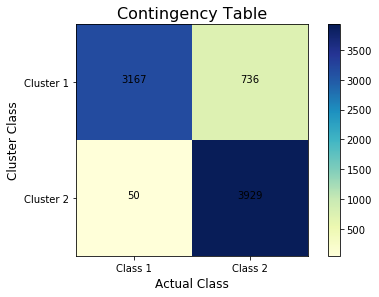

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.580535
Completeness Score: 0.595065
V-Measure Score: 0.587710
Adjusted Rand Index: 0.640848
Adjusted Mutual Information: 0.580496


In [147]:
# Apply K-means clustering with k=2 using the TF-IDF data. Use random_state=0, max_iter >= 1000, n_init>=30.
k_means, km = k_means_clustering(X_tfidf, dataset_binary_target, n_clusters=2,random_state=0,max_iter=1000,n_init=30)

In [148]:
# QUESTION 4: Report the plot of the percent of variance the top r principle compo-
# nents can retain v.s. r, for r = 1 to 1000.

SVD complete after 20.040269 seconds
Plot Percent of Variance


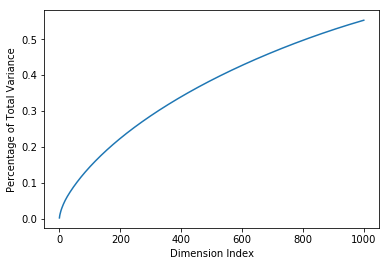

In [150]:
svd_dataset, svd = svd_dimension_reduction(X_tfidf, n_components = 1000)
plot_percent_variance(svd)

In [151]:
# QUESTION 5:
# Let r be the dimension that we want to reduce the data to (i.e. n components).
# Try r = 1; 2; 3; 5; 10; 20; 50; 100; 300, and plot the 5 measure scores v.s. r for both
# SVD and NMF.
# Report the best r choice for SVD and NMF respectively.
# Note: what is \best" after all? What if some measures contradict with each other? Here you are faced with this
# challenge that you need to decide which measure you value the most, and design your own standard of \best".
# Please explain your standard and justify it.

n_components: 1
SVD complete after 0.134472 seconds
Finished clustering with 30 seeds in 0.151788 seconds
Show Contingency Matrix:


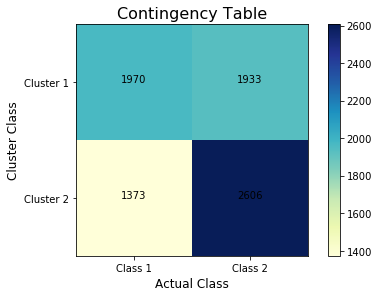

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.018910
Completeness Score: 0.019229
V-Measure Score: 0.019068
Adjusted Rand Index: 0.025839
Adjusted Mutual Information: 0.018820
n_components: 2
SVD complete after 0.125263 seconds
Finished clustering with 30 seeds in 0.164263 seconds
Show Contingency Matrix:


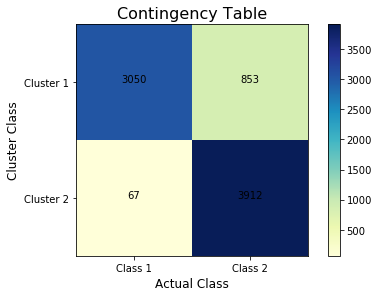

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.530919
Completeness Score: 0.548302
V-Measure Score: 0.539471
Adjusted Rand Index: 0.587557
Adjusted Mutual Information: 0.530876
n_components: 3
SVD complete after 0.130621 seconds
Finished clustering with 30 seeds in 0.163099 seconds
Show Contingency Matrix:


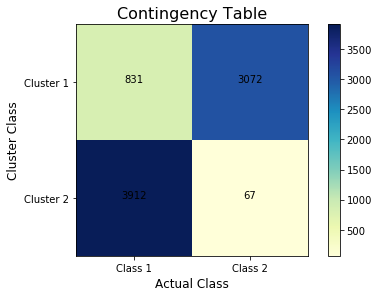

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.537803
Completeness Score: 0.554446
V-Measure Score: 0.545998
Adjusted Rand Index: 0.596148
Adjusted Mutual Information: 0.537761
n_components: 5
SVD complete after 0.150882 seconds
Finished clustering with 30 seeds in 0.199954 seconds
Show Contingency Matrix:


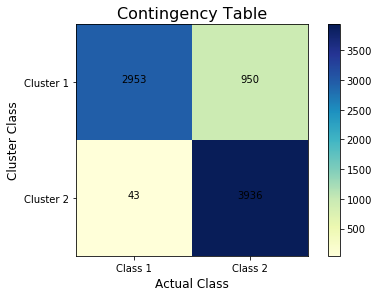

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.518223
Completeness Score: 0.540840
V-Measure Score: 0.529290
Adjusted Rand Index: 0.559499
Adjusted Mutual Information: 0.518179
n_components: 10
SVD complete after 0.170901 seconds
Finished clustering with 30 seeds in 0.229945 seconds
Show Contingency Matrix:


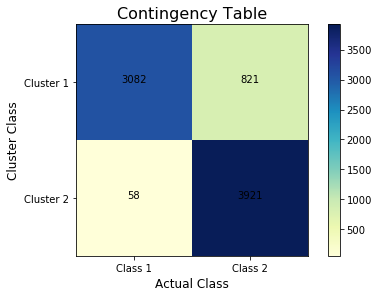

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.547104
Completeness Score: 0.563991
V-Measure Score: 0.555419
Adjusted Rand Index: 0.603617
Adjusted Mutual Information: 0.547062
n_components: 20
SVD complete after 0.302027 seconds
Finished clustering with 30 seeds in 0.363444 seconds
Show Contingency Matrix:


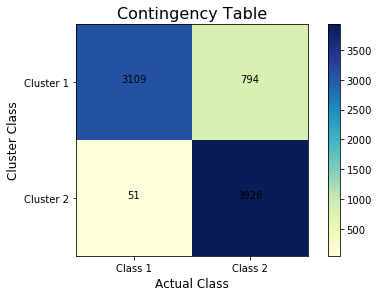

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.560716
Completeness Score: 0.577137
V-Measure Score: 0.568808
Adjusted Rand Index: 0.617100
Adjusted Mutual Information: 0.560676
n_components: 50
SVD complete after 0.672110 seconds
Finished clustering with 30 seeds in 0.739166 seconds
Show Contingency Matrix:


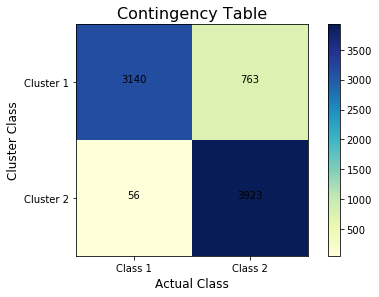

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.567255
Completeness Score: 0.582318
V-Measure Score: 0.574688
Adjusted Rand Index: 0.627510
Adjusted Mutual Information: 0.567215
n_components: 100
SVD complete after 1.311025 seconds
Finished clustering with 30 seeds in 1.386401 seconds
Show Contingency Matrix:


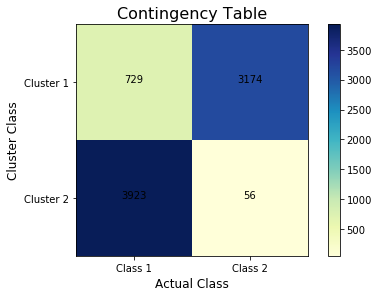

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.578560
Completeness Score: 0.592509
V-Measure Score: 0.585451
Adjusted Rand Index: 0.641255
Adjusted Mutual Information: 0.578521
n_components: 300
SVD complete after 3.797411 seconds
Finished clustering with 30 seeds in 3.697266 seconds
Show Contingency Matrix:


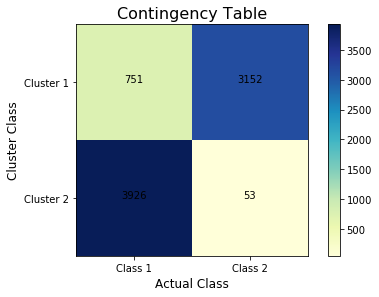

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.573359
Completeness Score: 0.588206
V-Measure Score: 0.580688
Adjusted Rand Index: 0.633555
Adjusted Mutual Information: 0.573320


In [152]:
svd_homogeneity_1 = []
svd_completeness_1 = []
svd_v_measure_1 = []
svd_adjusted_mutual_info_1 = []
svd_adjusted_rand_index_1 = []

for r in [1, 2, 3, 5, 10, 20, 50, 100, 300]:
    print('n_components:', r)
    svd_dataset,svd = svd_dimension_reduction(X_tfidf, n_components = r)
    k_means, km = k_means_clustering(svd_dataset, dataset_binary_target, n_clusters=2,random_state=0,max_iter=1000,n_init=30)
    svd_homogeneity_1.append(k_means['homogeneity'])
    svd_completeness_1.append(k_means['completeness'])
    svd_v_measure_1.append(k_means['v_measure'])
    svd_adjusted_mutual_info_1.append(k_means['adjusted_mutual_info'])
    svd_adjusted_rand_index_1.append(k_means['adjusted_rand_index'])
    


n_components: 1
NMF complete after 0.176018 seconds
Finished clustering with 30 seeds in 0.157372 seconds
Show Contingency Matrix:


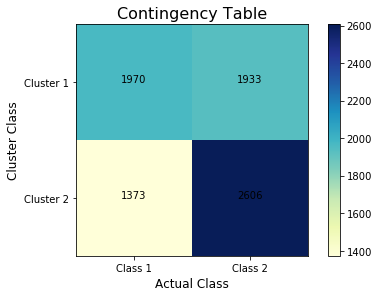

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.018910
Completeness Score: 0.019229
V-Measure Score: 0.019068
Adjusted Rand Index: 0.025839
Adjusted Mutual Information: 0.018820
n_components: 2
NMF complete after 0.371114 seconds
Finished clustering with 30 seeds in 0.134475 seconds
Show Contingency Matrix:


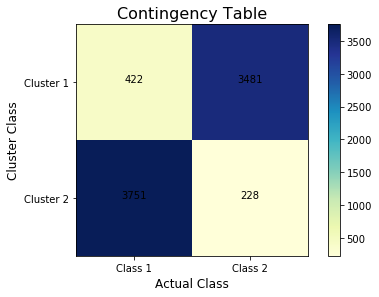

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.592964
Completeness Score: 0.594411
V-Measure Score: 0.593687
Adjusted Rand Index: 0.697299
Adjusted Mutual Information: 0.592927
n_components: 3
NMF complete after 0.515551 seconds
Finished clustering with 30 seeds in 0.119713 seconds
Show Contingency Matrix:


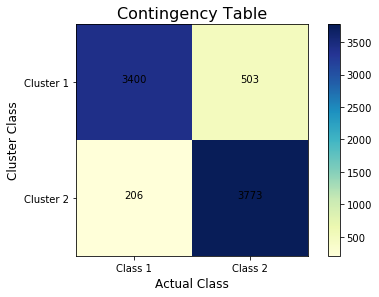

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.571965
Completeness Score: 0.574927
V-Measure Score: 0.573442
Adjusted Rand Index: 0.672517
Adjusted Mutual Information: 0.571926
n_components: 5
NMF complete after 2.027168 seconds
Finished clustering with 30 seeds in 0.172401 seconds
Show Contingency Matrix:


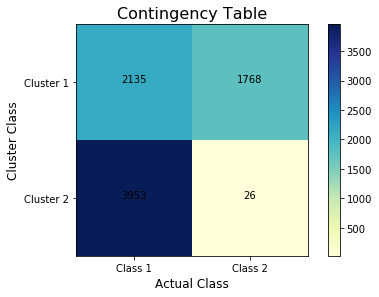

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.253134
Completeness Score: 0.327101
V-Measure Score: 0.285403
Adjusted Rand Index: 0.203906
Adjusted Mutual Information: 0.253065
n_components: 10
NMF complete after 1.220886 seconds
Finished clustering with 30 seeds in 0.245677 seconds
Show Contingency Matrix:


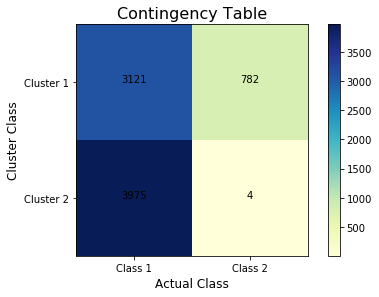

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.104493
Completeness Score: 0.223209
V-Measure Score: 0.142348
Adjusted Rand Index: 0.042771
Adjusted Mutual Information: 0.104411
n_components: 20
NMF complete after 3.855553 seconds
Finished clustering with 30 seeds in 0.322713 seconds
Show Contingency Matrix:


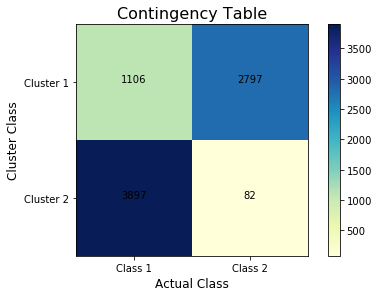

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.448020
Completeness Score: 0.473079
V-Measure Score: 0.460209
Adjusted Rand Index: 0.487914
Adjusted Mutual Information: 0.447969
n_components: 50
NMF complete after 34.168302 seconds
Finished clustering with 30 seeds in 0.603904 seconds
Show Contingency Matrix:


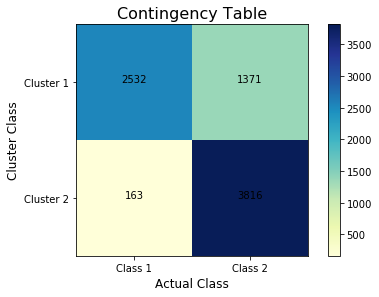

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.339037
Completeness Score: 0.365852
V-Measure Score: 0.351935
Adjusted Rand Index: 0.372949
Adjusted Mutual Information: 0.338976
n_components: 100
NMF complete after 116.187245 seconds
Finished clustering with 30 seeds in 0.761564 seconds
Show Contingency Matrix:


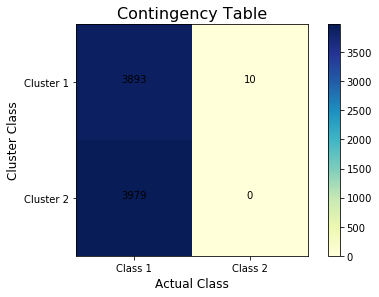

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.001288
Completeness Score: 0.091729
V-Measure Score: 0.002540
Adjusted Rand Index: 0.000055
Adjusted Mutual Information: 0.001191
n_components: 300
NMF complete after 796.305023 seconds
Finished clustering with 30 seeds in 3.236135 seconds
Show Contingency Matrix:


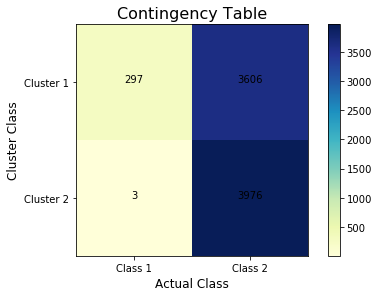

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.036575
Completeness Score: 0.156739
V-Measure Score: 0.059310
Adjusted Rand Index: 0.007000
Adjusted Mutual Information: 0.036486


In [153]:
nmf_homogeneity_1 = []
nmf_completeness_1 = []
nmf_v_measure_1 = []
nmf_adjusted_mutual_info_1 = []
nmf_adjusted_rand_index_1 = []

for r in [1, 2, 3, 5, 10, 20, 50, 100, 300]:
    print('n_components:',r)
    nmf_dataset,nmf = nmf_dimension_reduction(X_tfidf, n_components = r)
    k_means,km = k_means_clustering(nmf_dataset, dataset_binary_target, n_clusters=2,random_state=0,max_iter=1000,n_init=30)
    nmf_homogeneity_1.append(k_means['homogeneity'])
    nmf_completeness_1.append(k_means['completeness'])
    nmf_v_measure_1.append(k_means['v_measure'])
    nmf_adjusted_mutual_info_1.append(k_means['adjusted_mutual_info'])
    nmf_adjusted_rand_index_1.append(k_means['adjusted_rand_index'])
    


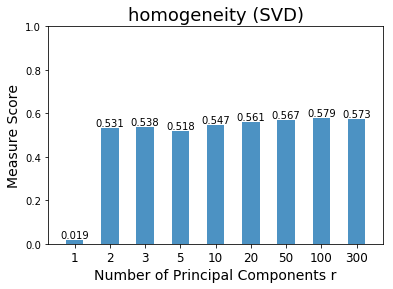

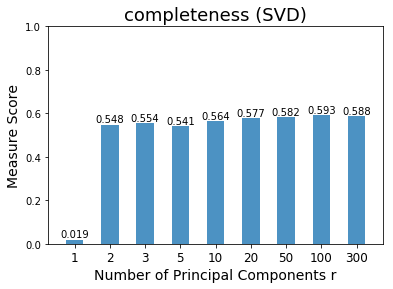

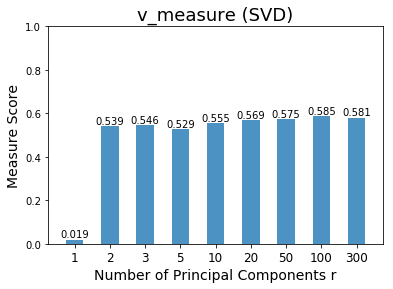

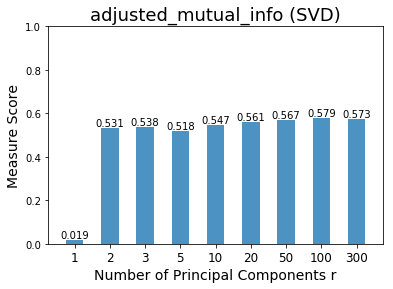

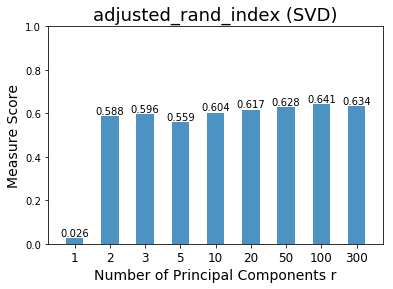

In [154]:
plot_histogram('SVD', 'homogeneity',svd_homogeneity_1)
plot_histogram('SVD', 'completeness',svd_completeness_1)
plot_histogram('SVD', 'v_measure',svd_v_measure_1)
plot_histogram('SVD', 'adjusted_mutual_info',svd_adjusted_mutual_info_1)
plot_histogram('SVD', 'adjusted_rand_index',svd_adjusted_rand_index_1)
               

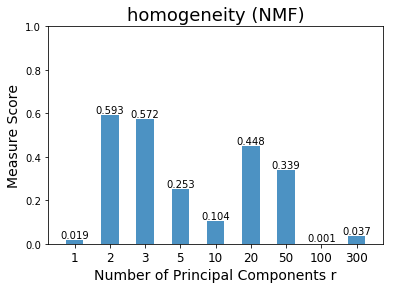

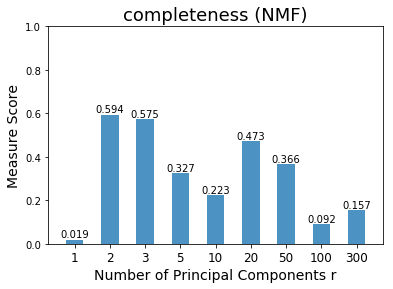

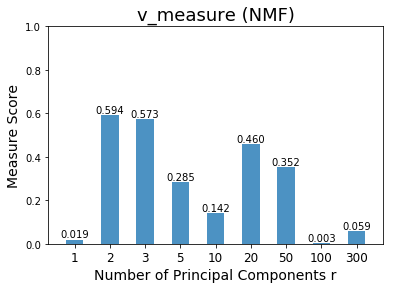

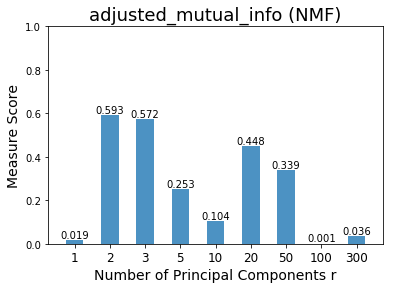

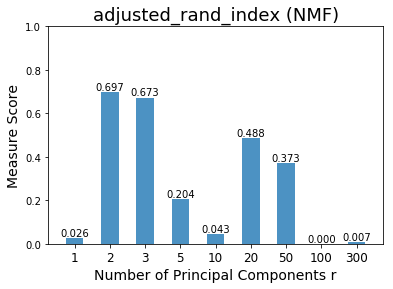

In [155]:
plot_histogram('NMF', 'homogeneity',nmf_homogeneity_1)
plot_histogram('NMF', 'completeness',nmf_completeness_1)
plot_histogram('NMF', 'v_measure',nmf_v_measure_1)
plot_histogram('NMF', 'adjusted_mutual_info',nmf_adjusted_mutual_info_1)
plot_histogram('NMF', 'adjusted_rand_index',nmf_adjusted_rand_index_1)
               

In [ ]:
# QUESTION 6: How do you explain the non-monotonic behavior of the measures as r
# increases?

In [ ]:
# QUESTION 7: Visualize the clustering results for:
#  SVD with its best r
#  NMF with its best r

SVD complete after 3.822798 seconds
Finished clustering with 30 seeds in 4.292045 seconds
Show Contingency Matrix:


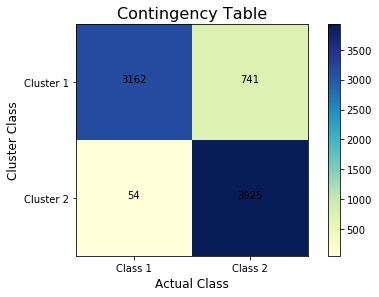

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.575969
Completeness Score: 0.590426
V-Measure Score: 0.583108
Adjusted Rand Index: 0.637197
Adjusted Mutual Information: 0.575930


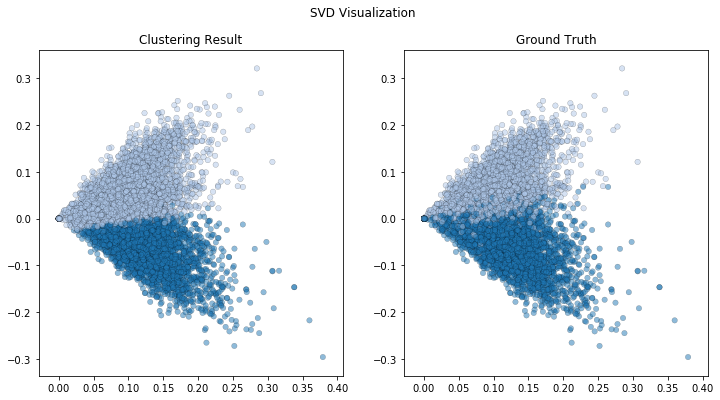

In [179]:
# Best r for SVD is 300
best_svd_dataset,best_svd = svd_dimension_reduction(X_tfidf, n_components = 300)
best_k_means, best_svd_km = k_means_clustering(best_svd_dataset, dataset_binary_target, n_clusters=2,random_state=0,max_iter=1000,n_init=30)
i_love_graphing_points(best_svd_km, best_svd_dataset, dataset_binary_target, 'SVD')

NMF complete after 0.347025 seconds
Finished clustering with 30 seeds in 0.117819 seconds
Show Contingency Matrix:


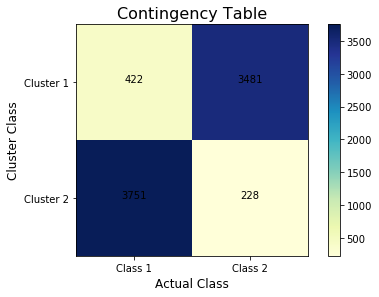

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.592964
Completeness Score: 0.594411
V-Measure Score: 0.593687
Adjusted Rand Index: 0.697299
Adjusted Mutual Information: 0.592927


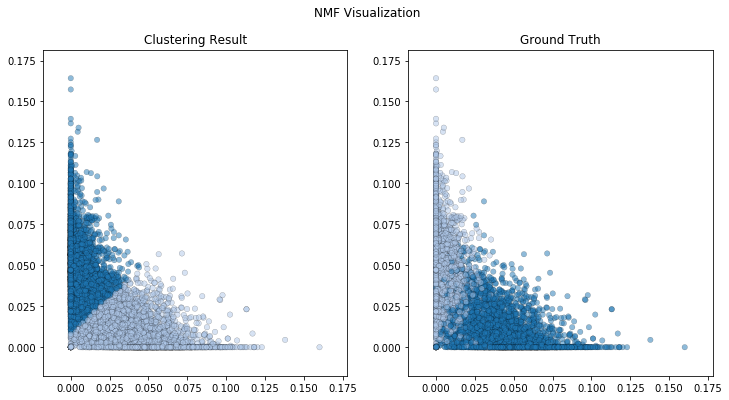

In [181]:
# Best r for NMF is 2
best_nmf_dataset,best_svd = nmf_dimension_reduction(X_tfidf, n_components = 2)
best_k_means, best_nmf_km = k_means_clustering(best_nmf_dataset, dataset_binary_target, n_clusters=2,random_state=0,max_iter=1000,n_init=30)
i_love_graphing_points(best_nmf_km, best_nmf_dataset, dataset_binary_target, 'NMF')

In [ ]:
# QUESTION 8: Visualize the transformed data as in part (a).

In [ ]:
# QUESTION 9: Can you justify why the \logarithm transformation" may improve the
# clustering results?

In [ ]:
# QUESTION 10: Report the new clustering measures (except for the contingency ma-
# trix) for the clustering results of the transformed data.

In [ ]:
# QUESTION 11: Repeat the following for 20 categories using the same parameters as in
# 2-class case:
#  Transform corpus to TF-IDF matrix;
#  Directly perform K-means and report the 5 measures and the contingency matrix;

In [30]:
km_20 = pickle.load(open("km_20.pkl","rb"))
km_2 = pickle.load(open("km_2.pkl","rb"))

In [32]:
# pickle.dump(km_2,open("km_2.pkl","wb"))
# pickle.dump(km_20,open("km_20.pkl","wb"))

In [33]:
# # Apply K-means clustering with k=20 using the TF-IDF data. Use random_state=0, max_iter >= 1000, n_init>=30.
# N_CLUSTERS = 20
# RANDOM_STATE = 0
# MAX_ITER = 1000
# N_INIT = 30

# km_20 = k_means_clustering(nmf_dataset, n_clusters=N_CLUSTERS,random_state=RANDOM_STATE,max_iter=MAX_ITER,n_init=N_INIT)


# # km_20 = KMeans(n_clusters=N_CLUSTERS,random_state=RANDOM_STATE,max_iter=MAX_ITER,n_init=N_INIT)
# # start = time.time()
# # km_20.fit(X_tfidf)
# # print("Finished clustering with %i seeds in %f seconds" % (N_INIT, time.time()-start))

QUESTION 11: Report 5 Measures for K-Means Clustering for 20 classes
 
Contingency Matrix:
[[ 54  47   2   0   0   0  10   0   0   6   8  24   8 406 406   1   0   1
    0   0]
 [ 89  77   0   0  29   4   8   0   0   9  83 372   3  46 241   5   0   3
    0  16]
 [125  38   0   0  16  76  16   0   0  55  10  44 147   5 317   0   0   2
    2 129]
 [ 29  68   0   2  15  29 317   1   0  77  35   6  72   6 234   1   0   1
    0  70]
 [  0 118   0   0   0   0   1   0   0   0   0   2   0   0 209 228 363  67
    0   2]
 [  0 121  28   2   0   0   0   0   0   0   0   0   0   0 144  53  20 624
    1   3]
 [  0 134  13 476   0   0   0  26 108   0   0   0   0   1 197   6   0   5
   28   0]
 [  0 100  78  31   0   0   0 345  45   0   0   0   2   0 113   0   0   4
  281   0]]


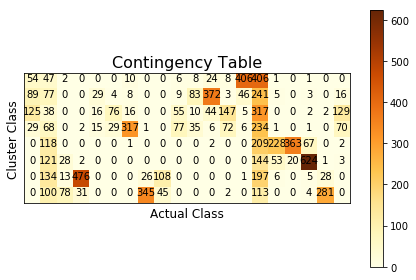

In [38]:
print("QUESTION 11: Report 5 Measures for K-Means Clustering for 20 classes\n ")
contin_matrix = metrics.cluster.contingency_matrix(dataset.target, km_20.labels_)
print("Contingency Matrix:")
print(contin_matrix)
# print_cluster_metrics(dataset.target, km_20)

plot_contingency_table(contin_matrix, actual_class_names=[], cluster_class_names=[])

In [ ]:
# QUESTION 12: Try different dimensions for both truncated SVD and NMF dimensionality reduction
# techniques and the different transformations of the obtained feature vectors as
# outlined in above parts.
# You don't need to report everything you tried, which will be tediously long. You are asked,
# however, to report your best combination, and quantitatively report how much better
# it is compared to other combinations. You should also include typical combinations
# showing what choices are desirable (or undesirable).

In [137]:
nmf_homogeneity = []
nmf_completeness = []
nmf_v_measure = []
nmf_adjusted_mutual_info = []
nmf_adjusted_rand_index = []

svd_homogeneity = []
svd_completeness = []
svd_v_measure = []
svd_adjusted_mutual_info = []
svd_adjusted_rand_index = []


for r in range(300,1000,100):
    print('n_components:',r)
    nmf_dataset,nmf = nmf_dimension_reduction(X_tfidf, n_components = r)
    k_means_nmf = k_means_clustering(nmf_dataset, dataset.target, n_clusters=20,random_state=0,max_iter=5,n_init=5)
    nmf_homogeneity.append(k_means_nmf['homogeneity'])
    nmf_completeness.append(k_means_nmf['completeness'])
    nmf_v_measure.append(k_means_nmf['v_measure'])
    nmf_adjusted_mutual_info.append(k_means_nmf['adjusted_mutual_info'])
    nmf_adjusted_rand_index.append(k_means_nmf['adjusted_rand_index'])
    
    svd_dataset,svd = svd_dimension_reduction(X_tfidf, n_components = r)
    k_means_svd = k_means_clustering(svd_dataset, dataset.target, n_clusters=20,random_state=0,max_iter=5,n_init=5)
    svd_homogeneity.append(k_means_svd['homogeneity'])
    svd_completeness.append(k_means_svd['completeness'])
    svd_v_measure.append(k_means_svd['v_measure'])
    svd_adjusted_mutual_info.append(k_means_svd['adjusted_mutual_info'])
    svd_adjusted_rand_index.append(k_means_svd['adjusted_rand_index'])

In [138]:

plot_histogram('SVD', 'homogeneity',svd_homogeneity, x_labels=range(300,1000,100), height=range(1,len(svd_homogeneity)+1))
plot_histogram('SVD', 'completeness',svd_completeness, x_labels=range(300,1000,100), height=range(1,len(svd_completeness)+1))
plot_histogram('SVD', 'v_measure',svd_v_measure, x_labels=range(300,1000,100), height=range(1,len(svd_v_measure)+1))
plot_histogram('SVD', 'adjusted_mutual_info',svd_adjusted_mutual_info, x_labels=range(300,1000,100), height=range(1,len(svd_adjusted_mutual_info)+1))
plot_histogram('SVD', 'adjusted_rand_index',svd_adjusted_rand_index, x_labels=range(300,1000,100), height=range(1,len(svd_adjusted_rand_index)+1))

In [139]:
plot_histogram('NMF', 'homogeneity',nmf_homogeneity, height=range(1,len(nmf_homogeneity)+1))
plot_histogram('NMF', 'completeness',nmf_completeness, height=range(1,len(nmf_completeness)+1))
plot_histogram('NMF', 'v_measure',nmf_v_measure, height=range(1,len(nmf_v_measure)+1))
plot_histogram('NMF', 'adjusted_mutual_info',nmf_adjusted_mutual_info, height=range(1,len(nmf_adjusted_mutual_info)+1))
plot_histogram('NMF', 'adjusted_rand_index',nmf_adjusted_rand_index, height=range(1,len(nmf_adjusted_rand_index)+1))
               